In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_everything(7)

In [2]:
root_dir = "../NNATT dataset"

dfs = []
class_names = []

if os.path.exists(root_dir):
    for mineral_folder in sorted(os.listdir(root_dir)):
        mineral_path = os.path.join(root_dir, mineral_folder)
        
        # Check for directory
        if not os.path.isdir(mineral_path):
            continue
            
        # Look for 30fps folder
        fps_path = os.path.join(mineral_path, "30fps")
        if not os.path.exists(fps_path):
            continue
            
        # Look for CSV files
        csv_files = [f for f in os.listdir(fps_path) if f.endswith(".csv")]
        
        if not csv_files:
            continue
            
        target_file = None
        if len(csv_files) == 1:
            target_file = csv_files[0]
        else:
            # Look for planar1
            planar_files = [f for f in csv_files if "planar1" in f.lower()]
            if planar_files:
                target_file = planar_files[0]
            else:
                target_file = csv_files[0]
        
        if target_file:
            full_path = os.path.join(fps_path, target_file)
            try:
                dfs.append(pd.read_csv(full_path, dtype=np.float32, header=None))
                class_names.append(mineral_folder)
                print(f"Loaded {mineral_folder}: {target_file}")
            except Exception as e:
                print(f"Error loading {full_path}: {e}")

print("Class names:", class_names)
num_classes = len(class_names)
print(f"Number of classes derived: {num_classes}")

dataset = []
for i, d in enumerate(dfs):
    class_num =  np.array([i] * d.shape[0], dtype=np.float32)
    d = np.c_[d, class_num] 
    dataset.extend(d) 
dataset = np.array(dataset)

X = dataset[:, :-1]
y = dataset[:, -1:]
print("Data shape:", X.shape, X[0, -5:], y.shape, np.unique(y))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print("Split shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

class RockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

train_dataset = RockDataset(X_train, y_train)
test_dataset = RockDataset(X_test, y_test)

class Configs():
    def __init__(self):
        self.batch_size = 16
        self.lr = 0.0001
        self.epochs = 7
        self.weight_decay = 0.

configs = Configs()

train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=configs.batch_size, shuffle=False)


model_results = {}

Loaded Albit: PROFILES_Albit113_planar1_30FPSnormalised.csv
Loaded Calcite: PROFILES_AiDEXA_Calcite_planar1_30FPSnormalised.csv
Loaded Dolomit: PROFILES_Dolomit18_planar1_30FPSnormalised.csv
Loaded Feldspat: PROFILES_Feldspat19_planar1_30FPSnormalised.csv
Loaded Quarz: PROFILES_Quarz_planar1_30FPSnormalised.csv
Loaded Rhodocrosite: PROFILES_Rhodochrosite_planar1_30FPSnormalised.csv
Loaded Tile: PROFILES_Tile_30FPSnormalised.csv
Class names: ['Albit', 'Calcite', 'Dolomit', 'Feldspat', 'Quarz', 'Rhodocrosite', 'Tile']
Number of classes derived: 7
Data shape: (70000, 1060) [3. 3. 3. 3. 3.] (70000, 1) [0. 1. 2. 3. 4. 5. 6.]
Split shapes: (56000, 1060) (14000, 1060) (56000, 1) (14000, 1)


In [3]:
class Configs():
    def __init__(self):
        self.batch_size = 16
        self.lr = 0.0001
        self.epochs = 10
        self.weight_decay = 0.

configs = Configs()

In [4]:
# --- 1D CNN Implementation ---
print("\n--- Training 1D CNN ---")

class Model1DCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.batch_norm_1 = nn.BatchNorm1d(num_features=(1))
        self.conv1 = nn.Conv1d(1, 16, kernel_size=9, stride=3)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=9, stride=3)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=32)

        
        self.fnn1 = nn.Linear(32, num_classes) # Dynamic classes
    
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool1d(kernel_size=2)
        self.global_pool = nn.AdaptiveMaxPool1d(output_size=1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.batch_norm_1(x)
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.relu(self.conv2(x))
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.layer_norm_1(x)
        x = self.fnn1(x)
        return x
    
model_cnn = Model1DCNN(num_classes=num_classes)


optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=configs.lr, weight_decay=configs.weight_decay)
criterion = nn.CrossEntropyLoss()

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(configs.epochs):
    avg_train_loss = []
    avg_train_acc = []
    
    model_cnn.train()
    for i, d in enumerate(train_loader):
        X_batch, y_batch = d
        y_batch = y_batch.squeeze().long()
        optimizer.zero_grad()
        outputs = model_cnn(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
                
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions = (predicted_labels == y_batch).sum().item()
        total_samples = y_batch.size(0)
        accuracy = correct_predictions / total_samples
        
        avg_train_loss.append(loss.item())
        avg_train_acc.append(accuracy)

    avg_acc = sum(avg_train_acc)/len(avg_train_acc)
    avg_loss = sum(avg_train_loss)/len(avg_train_loss)
    training_acc.append(avg_acc)
    training_loss.append(avg_loss)
    
    # Evaluation per epoch
    model_cnn.eval()
    avg_test_loss = []
    avg_test_acc = []
    
    with torch.no_grad():
        for i, d in enumerate(test_loader):
            X_batch, y_batch = d
            y_batch = y_batch.squeeze().long()
            outputs = model_cnn(X_batch)
            loss = criterion(outputs, y_batch)
                
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions = (predicted_labels == y_batch).sum().item()
            total_samples = y_batch.size(0)
            accuracy = correct_predictions / total_samples
            
            avg_test_loss.append(loss.item())
            avg_test_acc.append(accuracy)
            
    avg_test_acc_val = sum(avg_test_acc)/len(avg_test_acc)
    avg_test_loss_val = sum(avg_test_loss)/len(avg_test_loss)
    testing_acc.append(avg_test_acc_val)
    testing_loss.append(avg_test_loss_val)
    print(f"Epoch {epoch+1}: Train Acc {avg_acc:.4f}, Test Acc {avg_test_acc_val:.4f}")

# Final Evaluation for CNN to store predictions
all_preds_cnn = []
all_targets_cnn = []
model_cnn.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.squeeze().long()
        outputs = model_cnn(X_batch)
        _, predicted_labels = torch.max(outputs, 1)
        all_preds_cnn.extend(predicted_labels.numpy())
        all_targets_cnn.extend(y_batch.numpy())

cnn_accuracy = accuracy_score(all_targets_cnn, all_preds_cnn)
model_results['1D-CNN'] = {
    'accuracy': cnn_accuracy,
    'predictions': all_preds_cnn,
    'targets': all_targets_cnn
}


--- Training 1D CNN ---
Epoch 1: Train Acc 0.6710, Test Acc 0.7944
Epoch 2: Train Acc 0.7812, Test Acc 0.8196
Epoch 3: Train Acc 0.7953, Test Acc 0.8309
Epoch 4: Train Acc 0.8033, Test Acc 0.8335
Epoch 5: Train Acc 0.8098, Test Acc 0.8360
Epoch 6: Train Acc 0.8151, Test Acc 0.8476
Epoch 7: Train Acc 0.8196, Test Acc 0.8433
Epoch 8: Train Acc 0.8218, Test Acc 0.8516
Epoch 9: Train Acc 0.8268, Test Acc 0.8524
Epoch 10: Train Acc 0.8295, Test Acc 0.8543


In [5]:
# --- MLP Implementation ---
print("\n--- Training MLP ---")

class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.layers(x)

input_size = X.shape[1] 
model_mlp = MLP(input_size=input_size, num_classes=num_classes)


optimizer = torch.optim.Adam(params=model_mlp.parameters(), lr=configs.lr, weight_decay=configs.weight_decay)
criterion = nn.CrossEntropyLoss()

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(configs.epochs):
    avg_train_loss = []
    avg_train_acc = []
    
    model_mlp.train()
    for i, d in enumerate(train_loader):
        X_batch, y_batch = d
        y_batch = y_batch.squeeze().long()
        optimizer.zero_grad()
        outputs = model_mlp(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
                
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions = (predicted_labels == y_batch).sum().item()
        total_samples = y_batch.size(0)
        accuracy = correct_predictions / total_samples
        
        avg_train_loss.append(loss.item())
        avg_train_acc.append(accuracy)
        
    avg_acc = sum(avg_train_acc)/len(avg_train_acc)
    avg_loss = sum(avg_train_loss)/len(avg_train_loss)
    training_acc.append(avg_acc)
    training_loss.append(avg_loss)
    
    # Evaluation per epoch
    model_mlp.eval()
    avg_test_loss = []
    avg_test_acc = []
    
    with torch.no_grad():
        for i, d in enumerate(test_loader):
            X_batch, y_batch = d
            y_batch = y_batch.squeeze().long()
            outputs = model_mlp(X_batch)
            loss = criterion(outputs, y_batch)
                
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions = (predicted_labels == y_batch).sum().item()
            total_samples = y_batch.size(0)
            accuracy = correct_predictions / total_samples
            
            avg_test_loss.append(loss.item())
            avg_test_acc.append(accuracy)
            
    avg_test_acc_val = sum(avg_test_acc)/len(avg_test_acc)
    avg_test_loss_val = sum(avg_test_loss)/len(avg_test_loss)
    testing_acc.append(avg_test_acc_val)
    testing_loss.append(avg_test_loss_val)
    print(f"Epoch {epoch+1}: Train Acc {avg_acc:.4f}, Test Acc {avg_test_acc_val:.4f}")

# Final Evaluation for MLP
all_preds_mlp = []
all_targets_mlp = []
model_mlp.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_batch = y_batch.squeeze().long()
        outputs = model_mlp(X_batch)
        _, predicted_labels = torch.max(outputs, 1)
        all_preds_mlp.extend(predicted_labels.numpy())
        all_targets_mlp.extend(y_batch.numpy())

mlp_accuracy = accuracy_score(all_targets_mlp, all_preds_mlp)
model_results['MLP'] = {
    'accuracy': mlp_accuracy,
    'predictions': all_preds_mlp,
    'targets': all_targets_mlp
}


--- Training MLP ---
Epoch 1: Train Acc 0.9256, Test Acc 0.9481
Epoch 2: Train Acc 0.9398, Test Acc 0.9507
Epoch 3: Train Acc 0.9433, Test Acc 0.9518
Epoch 4: Train Acc 0.9453, Test Acc 0.9516
Epoch 5: Train Acc 0.9458, Test Acc 0.9536
Epoch 6: Train Acc 0.9478, Test Acc 0.9537
Epoch 7: Train Acc 0.9485, Test Acc 0.9558
Epoch 8: Train Acc 0.9473, Test Acc 0.9569
Epoch 9: Train Acc 0.9501, Test Acc 0.9551
Epoch 10: Train Acc 0.9518, Test Acc 0.9576



--- Training Random Forest ---
RFC Test Accuracy: 0.9632

--- Model Comparison ---
Accuracies: {'1D-CNN': 0.8542857142857143, 'MLP': 0.9575714285714285, 'RFC': 0.9632142857142857}
Best Model: RFC with Accuracy: 0.9632


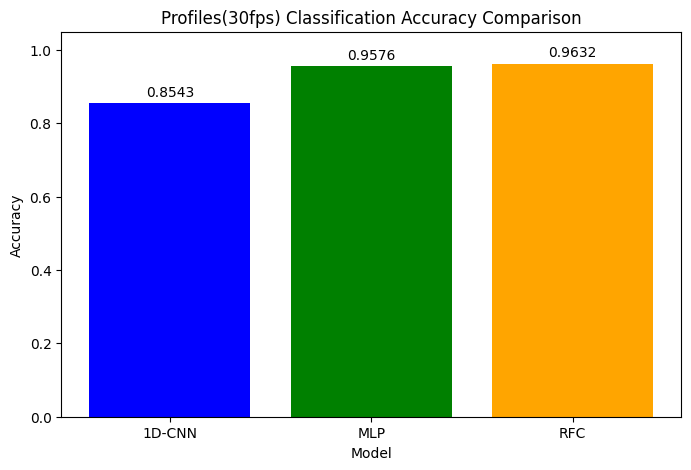


Classification Report for Best Model (RFC):
              precision    recall  f1-score   support

       Albit       0.88      0.90      0.89      2018
     Calcite       1.00      1.00      1.00      1985
     Dolomit       1.00      0.99      0.99      1991
    Feldspat       0.88      0.87      0.87      1967
       Quarz       0.99      0.99      0.99      2018
Rhodocrosite       0.99      1.00      1.00      2067
        Tile       1.00      1.00      1.00      1954

    accuracy                           0.96     14000
   macro avg       0.96      0.96      0.96     14000
weighted avg       0.96      0.96      0.96     14000



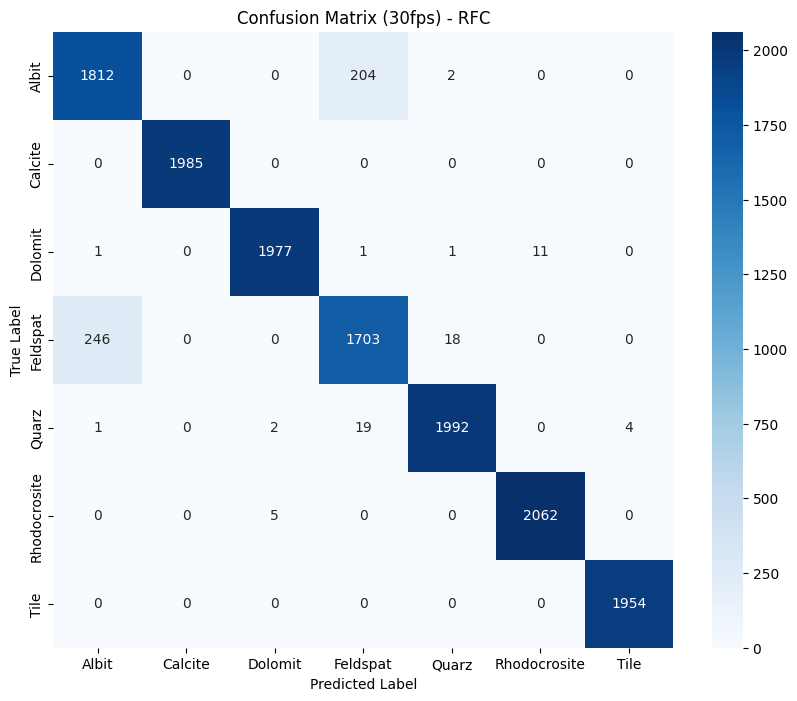

In [8]:
# --- Random Forest Classifier Implementation ---
print("\n--- Training Random Forest ---")

if 'X_train' in locals():
    
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    
    y_train_rf = y_train.ravel().astype(int)
    y_test_rf = y_test.ravel().astype(int)

    rf_model.fit(X_train, y_train_rf)
    
    y_pred_rf = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)
    
    model_results['RFC'] = {
        'accuracy': rf_accuracy,
        'predictions': y_pred_rf,
        'targets': y_test_rf
    }
    
    print(f"RFC Test Accuracy: {rf_accuracy:.4f}")

# --- Comparison and Analysis ---
print("\n--- Model Comparison ---")

accuracies = {name: res['accuracy'] for name, res in model_results.items()}
best_model_name = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model_name]

print(f"Accuracies: {accuracies}")
print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")

# Bar Chart
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange'])
plt.title('Profiles(30fps) Classification Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
for i, v in enumerate(accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', va='bottom')
plt.savefig('../results/accuracy_comparison_profiles_30fps.png')
plt.show()

# Classification Report & Confusion Matrix for Best Model
best_preds = model_results[best_model_name]['predictions']
best_targets = model_results[best_model_name]['targets']


target_names = class_names if 'class_names' in locals() and len(class_names) == len(np.unique(best_targets)) else None

print(f"\nClassification Report for Best Model ({best_model_name}):")
print(classification_report(best_targets, best_preds, target_names=target_names))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(best_targets, best_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names if target_names else "auto", 
            yticklabels=target_names if target_names else "auto")
plt.title(f'Confusion Matrix (30fps) - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('../results/confusion_matrix_profiles_30fps.png')
plt.show()

In [9]:
# --- Save Models ---
print("\n--- Saving Models ---")
torch.save(model_cnn.state_dict(), '../models/model_cnn_profiles_30fps.pth')
torch.save(model_mlp.state_dict(), '../models/model_mlp_profiles_30fps.pth')
joblib.dump(rf_model, '../models/model_rf_profiles_30fps.joblib')
print("Models saved in ../models/")


--- Saving Models ---
Models saved in ../models/
